In [2]:
import keras

In [3]:
from keras.applications import MobileNetV2
from keras.layers import AveragePooling2D,Dropout,Flatten,Dense,Input
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.mobilenet_v2 import preprocess_input
from keras.preprocessing.image import img_to_array, load_img
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import cv2

In [4]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_shape=(128,128,3))

9412608/9406464 [==============================] - 4s 0us/step


In [5]:
headModel = baseModel.output
headModel = AveragePooling2D(2,2)(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dense(64,activation = 'relu')(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [6]:
for layer in  enumerate(baseModel.layers):
    if layer[0]<100:
        layer[1].trainable = False
    else:
        layer[1].trainable = True

In [7]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [8]:
from keras.models import model_from_json
model.load_weights('weights_face_mask_6.h5')

In [9]:
labels_dics = {1:'Mask',0:'No Mask'}
color_dics = {1:(0,255,0),0:(255,0,0)}

In [10]:
from mtcnn.mtcnn import MTCNN

In [11]:
detector = MTCNN()

In [12]:
def mask_detector(img):
    image = cv2.imread(img)
    image1 = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image2 = image1.copy()
    faces = detector.detect_faces(image1)
    for face in faces:
        x, y, w, h = face['box']
        x,y = abs(x), abs(y)
        w,h = int(w+.1*w),int(h+.1*h)
        face_img=image1[y:y+h,x:x+w]
        resized = cv2.resize(face_img,(128,128))
        normalized = preprocess_input(resized)
        reshaped = np.reshape(normalized,(1,128,128,3))
        result = model.predict(reshaped)
        label = np.argmax(result,axis =1)[0]
        cv2.rectangle(image1,(x,y),(x+w,y+h),color_dics[label],2)
        cv2.rectangle(image1,(x,y-30),(x+w,y),color_dics[label],-1)
        cv2.putText(image1,labels_dics[label],(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,0),2)
    f = plt.figure(figsize = (14,10))
    f.add_subplot(1,2, 1)
    plt.imshow(image2)
    plt.xticks([]); plt.yticks([])
    f.add_subplot(1,2, 2)
    plt.imshow(image1)
    plt.xticks([]); plt.yticks([])

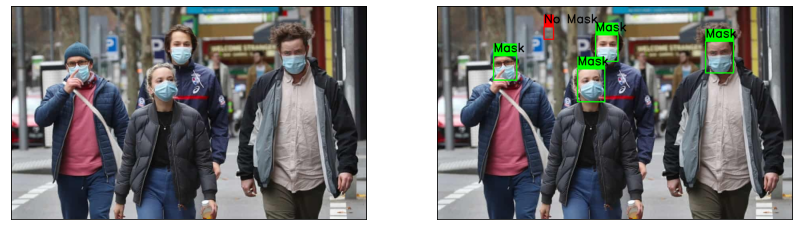

In [32]:
mask_detector('Images/74.jpeg')

In [ ]:
l = os.listdir('Images')

In [ ]:
for m in l[20:25]:
    mask_detector('Images/' + m)